#### This notebook describes:

#### 1) How the custom senescence score for figure 3 was calcuöated, using the hotspot gene scoring method

In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import colors

#import scvi
import anndata as ad

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

plt.rcParams['figure.figsize'] = (6, 6)

from IPython.core.display import display, HTML
import random

#Define a colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
#colorsComb = np.vstack([colors3, colors2])
#mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
from matplotlib import colors
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Helper function to split list in chunks
def chunks(lista, n):
    for i in range(0, len(lista), n):
        yield lista[i:i + n]
        
        plt.rcParams['figure.figsize'] = (6, 5)
sc.set_figure_params(dpi=100, vector_friendly=True)
def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())
plt.rcParams['figure.figsize'] = (6, 5)
sc.set_figure_params(dpi=100, vector_friendly=True)
sc.settings.figdir = "./figures/"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import scvi

Global seed set to 0


In [3]:
## frequently used variables
from matplotlib import colors
import matplotlib.pyplot as plt
colorsComb = np.vstack([plt.cm.Reds(np.linspace(0, 1, 128)), plt.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Along these Lines, a colourmap diverging from gray to red
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

## Some more Colour Maps
gray_violet = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "mediumvioletred", "indigo"], N = 128)
gray_blue = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "cornflowerblue", "darkblue"], N = 128)


def mysize(w, h, d):
    fig, ax = plt.subplots(figsize = (w, h), dpi = d)
    return(fig.gca())
#plt.rcParams['figure.figsize'] = (6, 5)
#sc.set_figure_params(dpi=120, vector_friendly=True)

In [4]:
import matplotlib.colors as colors
c_low = colors.colorConverter.to_rgba('orange', alpha = 0)
c_high = colors.colorConverter.to_rgba('red',alpha = 1)
cmap_transparent = colors.LinearSegmentedColormap.from_list('rb_cmap',[c_low, c_high], 512)

In [5]:
import matplotlib.colors as colors
c_low2 = colors.colorConverter.to_rgba('green', alpha = 0)
c_high2 = colors.colorConverter.to_rgba('darkblue',alpha = 1)
cmap_transparent2 = colors.LinearSegmentedColormap.from_list('rb_cmap',[c_low2, c_high2], 512)

In [7]:
print(f"squidpy=={sq.__version__}")
print(f"scanpy=={sc.__version__}")

squidpy==1.2.3
scanpy==1.9.3


In [11]:
import cell2location as c2l
from cell2location.utils import select_slide

# load data

In [14]:
##load
adata_vis = sc.read(f".h5ad")

In [15]:
adata_vis

AnnData object with n_obs × n_vars = 57787 × 12486
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'leiden', 'leiden_15', 'leiden_2', 'leiden_25', 'sampleID', 'treatment', 'VisiumSlides', 'technology', '_indices', '_scvi_batch', '_scvi_labels', 'AT0', 'AT1', 'AT2', 'Aberrant basaloid', 'Adventitial fibroblast', 'Alveolar fibroblast', 'Artery', 'B/Plasma', 'Basal', 'Basophil/Mast', 'Bronchial Vessel', 'Capillary', 'Capillary Aerocyte', 'Ciliated', 'Ciliated SFTPB+/SCGB1A1+', 'Dendritic', 'Ionocyte', 'Lymphatic', 'Macrophage C1Q hi', 'Macrophage CHI3L1+/CD9 hi/', 'Macrophage FABP4+', 'Macrophage IL1B+', 'Macrophage LYVE1+', 'Macrophage RETN+/VCAN+', 'Mesothelial', 'Monocyte', 'Mucous', 'Myofibroblast', 'NK', 'Peribronchial fibroblast', 'Pericyte', 'S

In [ ]:
Niche_NMF_palette = dict(zip(adata_vis.obs.Niche_NMF.cat.categories, adata_vis.uns["Niche_NMF_colors"]))

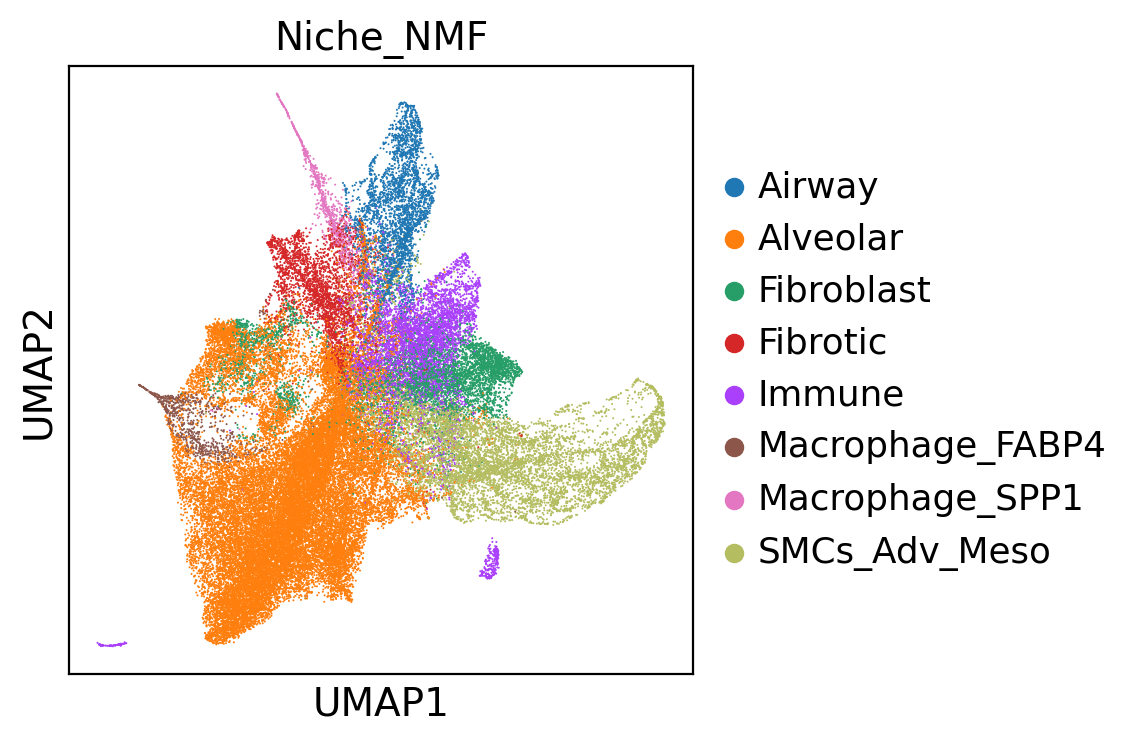

In [18]:
sc.pl.umap(adata_vis, color="Niche_NMF", palette=Niche_NMF_palette,)

# plotting

### code

In [20]:
import hotspot

In [18]:
def compute_scores_hotspot(adata,
                             genes,
                             layer=None,
                             n_neighbors = 30,
                             neighborhood_factor = 3,
                             gene_symbols = None,
                             use_rep = "X_scVI",
                             model = 'danb'
                            ):
    
    
    
    if use_rep is None:
        if layer is None:
            index = pynndescent.NNDescent(adata.X, n_neighbors=n_neighbors+1)
        else:
            index = pynndescent.NNDescent(adata.layers[layer], n_neighbors=n_neighbors+1)
    else:
        index = pynndescent.NNDescent(adata.obsm[use_rep], n_neighbors=n_neighbors+1)
    
    ind, dist = index.neighbor_graph
    ind, dist = ind[:, 1:], dist[:, 1:]
    
    ind = pd.DataFrame(ind, index=list(range(adata.n_obs)))
    neighbors = ind
    
    weights = compute_weights(dist, neighborhood_factor=neighborhood_factor)
    weights = pd.DataFrame(weights, index=neighbors.index,
                           columns=neighbors.columns)
    
       
    if layer is None:
        if scipy.sparse.issparse(adata.X):
            umi_counts = adata.X.sum(axis=1).A1
        else:
            umi_counts = adata.X.sum(axis=1)

    else:
        if scipy.sparse.issparse(adata.layers[layer]):
            umi_counts = adata.layers[layer].sum(axis=1).A1
        else:
            umi_counts = adata.layers[layer].sum(axis=1)
        
    if gene_symbols is None:
        counts_dense = Hotspot._counts_from_anndata(
                    adata[:, adata.var_names.isin(genes)], layer, dense=True)
    else: 
        counts_dense = Hotspot._counts_from_anndata(
                    adata[:, adata.var[gene_symbols].isin(genes)], layer, dense=True)
        

    scores = modules.compute_scores(
        counts_dense,
        model,
        umi_counts,
        neighbors.values,
        weights.values,
    )

    return scores

In [19]:
import pynndescent
import scipy.sparse 

In [20]:
import hotspot
from hotspot import modules
from hotspot.knn import compute_weights
from hotspot.hotspot import Hotspot

### code

In [21]:
senescence =["GLB1","TP53","SERPINE1","CDKN1A","CDKN1B","CDKN2B"]

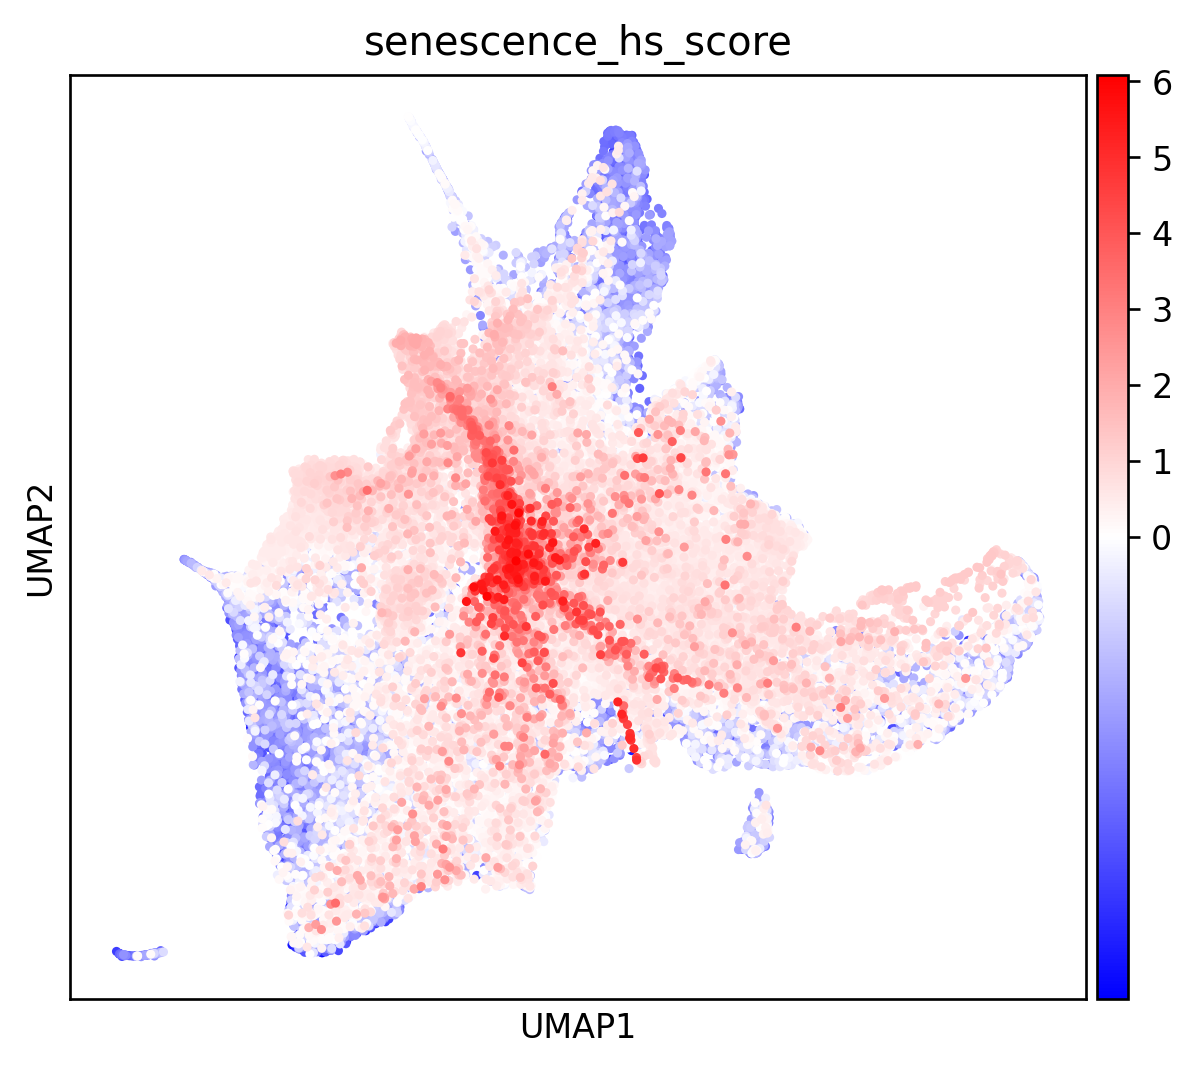

In [25]:
scores = compute_scores_hotspot(adata_vis, senescence,layer="log1p",n_neighbors = 30,neighborhood_factor = 3,gene_symbols = None,use_rep = "X_scVI",model = 'danb')
adata_vis.obs["senescence_hs_score"] = scores
sc.pl.umap(adata_vis, color = "senescence_hs_score", cmap = "bwr", ax = mysize(6, 5, 120), size = 30, vcenter=0,)# save="homeo_hs_score.pdf")

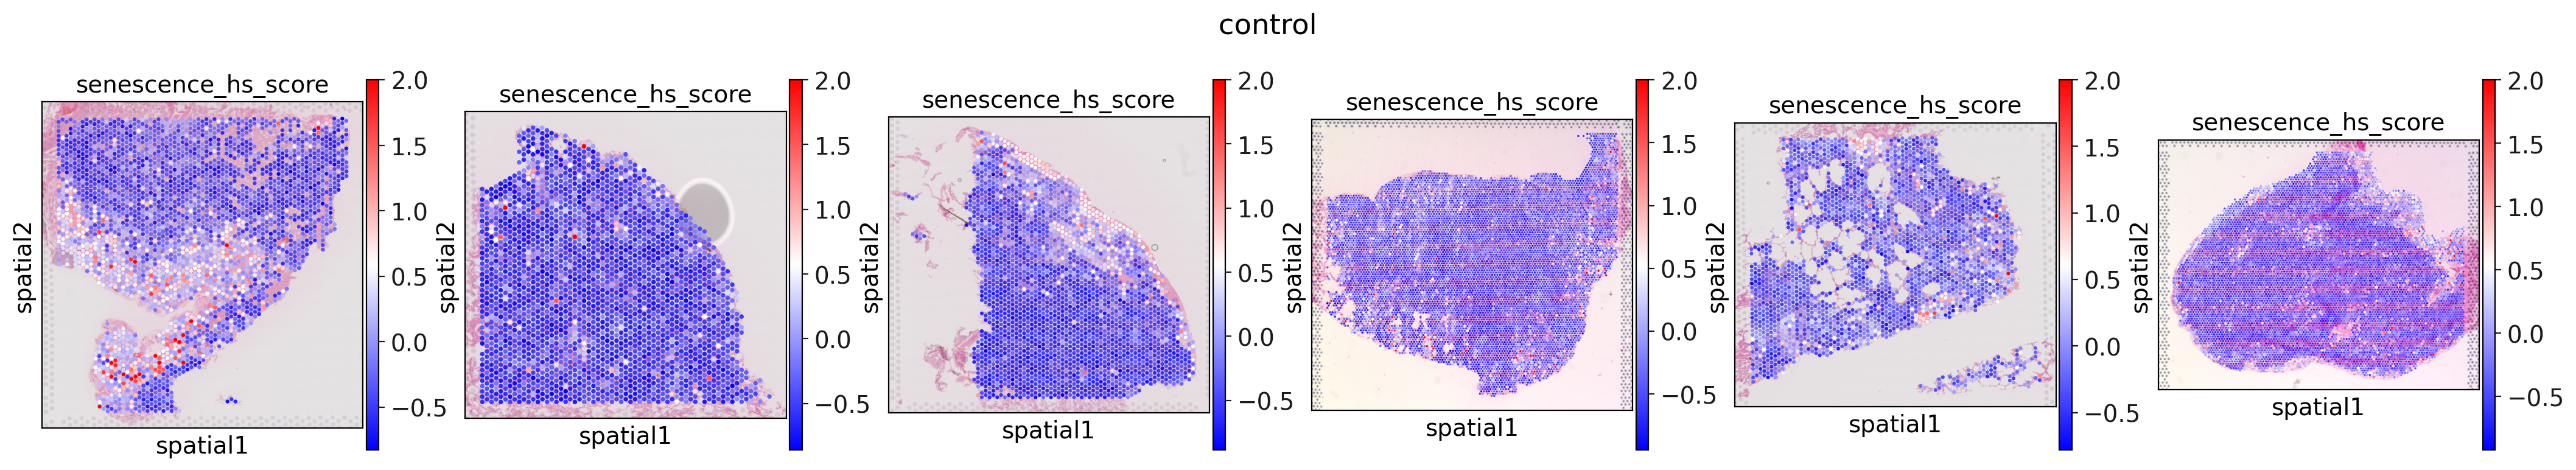

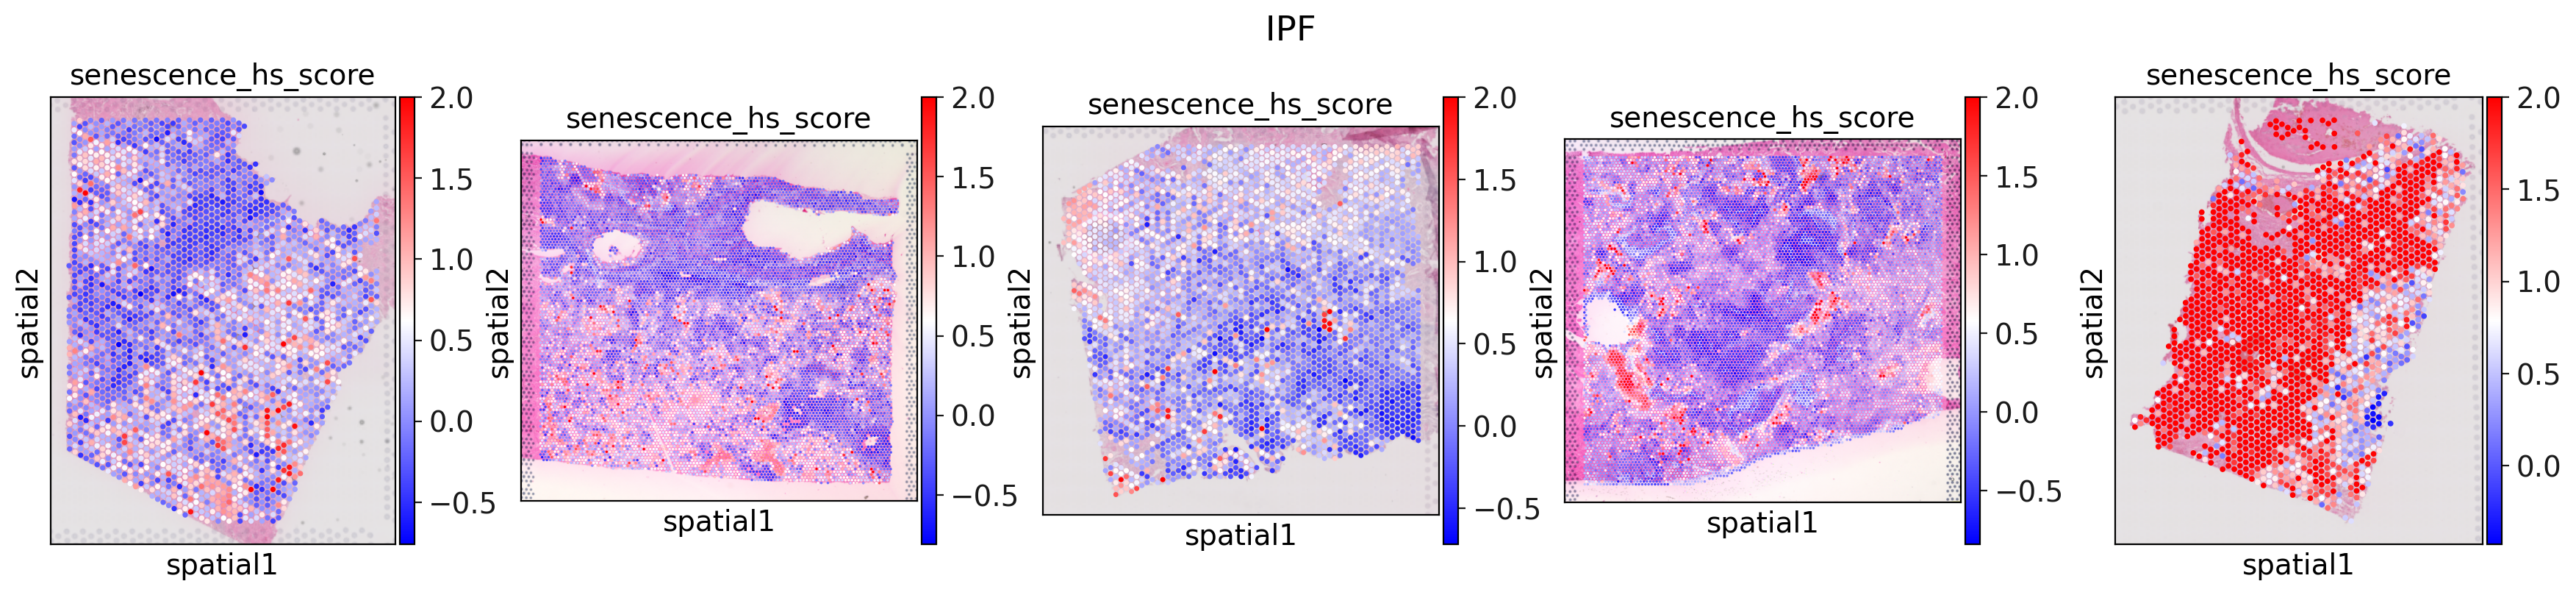

In [74]:
    #for i in fibs:
    gene = "senescence_hs_score"
    vmins = None
    vcenters= None
    vmaxs = 2
    img_keys='lowres'
    cmaps= "bwr"
    palettes=Niche_NMF_palette
    group= None #"Fibrotic"
    import matplotlib.pyplot as plt
    from cell2location.utils import select_slide
    fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6, figsize=(26,4), )
    plt.suptitle("                                                                          control                           ", y=1.05)
    with plt.rc_context({'axes.facecolor':  'white','figure.figsize': [4, 4]}):
        slide = select_slide(adata_vis, "90_C1_RO-730_Healthy_processed_CM")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax1, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "91_A1_RO-727_Healthy_processed_CM")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax2, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "91_B1_RO-728_Healthy_processed_CM")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax3, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "1217_0002_processed_aligned")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax4, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "92_A1_RO-3203_Healthy_processed_CM")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax5, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "1217_0004_processed_aligned")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax6, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
    plt.savefig("./figures/spatial_plot_senescence_hs_score_healthy_vmax2.pdf")   
    fig, (ax7, ax8, ax9, ax10, ax11,) = plt.subplots(1, 5, figsize=(22,4), )
    plt.suptitle("                                                                          IPF                           ", y=1.05)
    with plt.rc_context({'axes.facecolor':  'white','figure.figsize': [4, 4]}):
        slide = select_slide(adata_vis, "90_A1_H237762_IPF_processed_CM")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax7, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "1217_0001_processed_aligned")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax8, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "91_D1_24513-17_IPF_processed_CM")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax9, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "1217_0003_processed_aligned")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax10, show=False,vcenter= vcenters,palette=palettes, legend_loc=None)
        slide = select_slide(adata_vis, "92_D1_RO-3736_IPF_processed_CM")
        sc.pl.spatial(slide, cmap=cmaps,color=gene,size=1.3,img_key=img_keys,vmin=vmins, use_raw=False,layer="log1p",groups=group, vmax=vmaxs, ax=ax11, show=False,vcenter= vcenters,palette=palettes)
    plt.savefig("./figures/spatial_plot_senescence_hs_score_IPF_vmax2.pdf")              

In [23]:
import seaborn as sns
sns.reset_defaults()

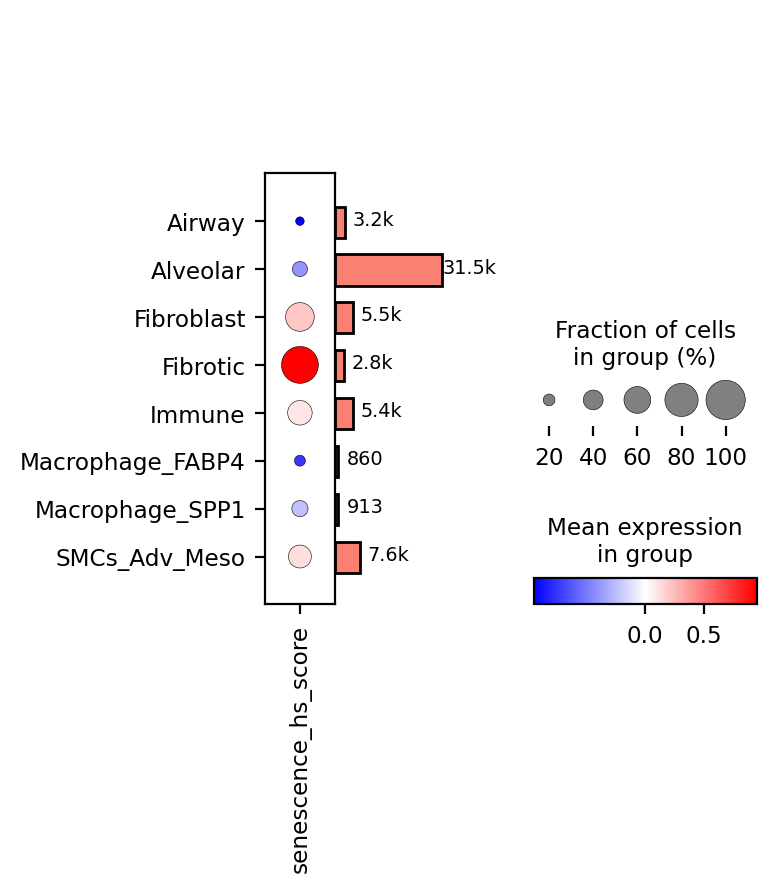

In [28]:
sc.pl.dotplot(adata_vis, var_names=["senescence_hs_score"], groupby="Niche_NMF", layer="log1p", vcenter=0, cmap = "bwr",
              return_fig=True, save="dotplot_senescence_hs_score_bwr.pdf").add_totals().legend(width=2).show()